# 20 · ORB en detalle: parámetros, efectos y visualización

> ORB = *Oriented FAST and Rotated BRIEF*: usa **FAST** para detectar puntos, estima **orientación** y construye un **descriptor BRIEF** rot-invariante y **binario** (rápido).

## 1) Parámetros de `cv2.ORB_create(...)`
orb = cv2.ORB_create(
    nfeatures=500,
    scaleFactor=1.2,
    nlevels=8,
    edgeThreshold=31,
    firstLevel=0,
    WTA_K=2,
    scoreType=cv2.ORB_HARRIS_SCORE,
    patchSize=31,
    fastThreshold=20
)
```

### Explicación y buenas prácticas
- **`nfeatures`**: límite superior de puntos totales; ORB reparte por cuadrícula y pirámide.
- **`scaleFactor`**: factor entre niveles de pirámide (>1). 1.2–1.3 típico.
- **`nlevels`**: niveles de pirámide (invariancia de escala vs. costo).
- **`edgeThreshold`**: margen de borde para evitar parches truncados (15–31 típico).
- **`firstLevel`**: nivel base (0 por defecto). Subirlo ignora detalles finos.
- **`WTA_K`**: votantes en BRIEF (2 rápido; 4 más discriminativo).
- **`scoreType`**: `HARRIS_SCORE` (estable) o `FAST_SCORE` (más rápido, menos estable).
- **`patchSize`**: tamaño del parche para el descriptor (31 buen compromiso).
- **`fastThreshold`**: umbral FAST; alto = estricto, bajo = sensible.


## 2) Carga de imagen

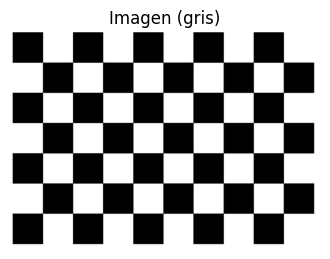

In [5]:
import cv2, numpy as np, matplotlib.pyplot as plt
from pathlib import Path

IMG_PATH = r"C:\\Users\\20808\\Documents\\Repositorios\\Vision_en_Robotica\\imagenes\\chess.png"
img_bgr = cv2.imread(IMG_PATH, cv2.IMREAD_UNCHANGED)
if img_bgr is None:
    raise FileNotFoundError(f"No se pudo cargar la imagen en {IMG_PATH}")
img_gray = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2GRAY)
img_rgb  = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)

plt.figure(figsize=(4,4)); plt.imshow(img_gray, cmap='gray'); plt.title("Imagen (gris)"); plt.axis('off'); plt.show()


## 3) Utilidades: detección ORB, conteos y visualización

In [6]:
def detect_orb(gray, nfeatures=500, scaleFactor=1.2, nlevels=8,
                edgeThreshold=31, firstLevel=0, WTA_K=2,
                scoreType=cv2.ORB_HARRIS_SCORE, patchSize=31, fastThreshold=20):
    orb = cv2.ORB_create(
        nfeatures=nfeatures,
        scaleFactor=scaleFactor,
        nlevels=nlevels,
        edgeThreshold=edgeThreshold,
        firstLevel=firstLevel,
        WTA_K=WTA_K,
        scoreType=scoreType,
        patchSize=patchSize,
        fastThreshold=fastThreshold
    )
    kps, des = orb.detectAndCompute(gray, None)
    return kps, des

def draw_keypoints_rgb(rgb, kps, rich=True):
    flags = cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS if rich else 0
    vis = cv2.drawKeypoints(rgb, kps, None, color=(0,255,0), flags=flags)
    return vis

def kp_stats(kps):
    if not kps:
        return {}, None
    levels = {}
    angles = []
    for kp in kps:
        levels[kp.octave] = levels.get(kp.octave, 0) + 1
        ang = kp.angle if kp.angle is not None else -1
        if ang >= 0:
            angles.append(ang)
    import numpy as np
    return levels, np.array(angles) if len(angles)>0 else None


## 4) Ejemplo base (parámetros prácticos)

Keypoints: 798 | Descriptor shape: (798, 32)


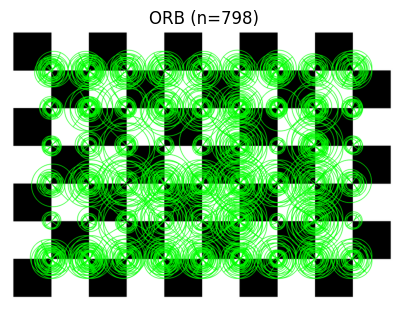

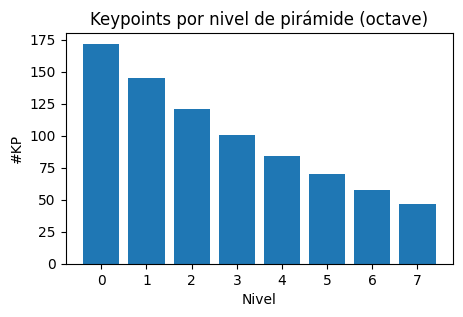

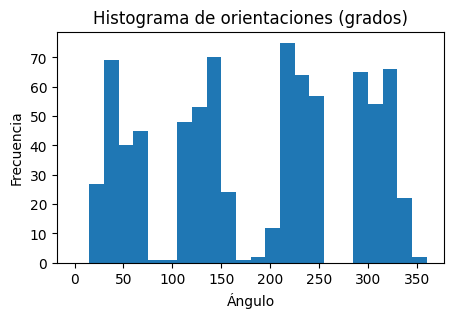

In [7]:
kps, des = detect_orb(img_gray, nfeatures=800, scaleFactor=1.2, nlevels=8,
                      edgeThreshold=31, firstLevel=0, WTA_K=2,
                      scoreType=cv2.ORB_HARRIS_SCORE, patchSize=31, fastThreshold=20)
print(f"Keypoints: {len(kps)} | Descriptor shape: {None if des is None else des.shape}")
vis = draw_keypoints_rgb(img_rgb, kps, rich=True)
plt.figure(figsize=(5,5)); plt.imshow(vis); plt.title(f"ORB (n={len(kps)})"); plt.axis('off'); plt.show()

levels, angles = kp_stats(kps)
if levels:
    xs = sorted(levels.keys())
    ys = [levels[x] for x in xs]
    plt.figure(figsize=(5,3)); plt.bar([str(x) for x in xs], ys)
    plt.title("Keypoints por nivel de pirámide (octave)"); plt.xlabel("Nivel"); plt.ylabel("#KP"); plt.show()
if angles is not None and angles.size>0:
    plt.figure(figsize=(5,3)); plt.hist(angles, bins=24, range=(0,360))
    plt.title("Histograma de orientaciones (grados)"); plt.xlabel("Ángulo"); plt.ylabel("Frecuencia"); plt.show()


## 5) Interactivo: ajusta los parámetros y observa el efecto

In [ ]:
import ipywidgets as widgets
from IPython.display import display, clear_output

w_nfeatures   = widgets.IntSlider(value=800, min=50, max=4000, step=50, description='nfeatures')
w_scaleFactor = widgets.FloatSlider(value=1.2, min=1.05, max=1.6, step=0.01, readout_format='.2f', description='scaleFactor')
w_nlevels     = widgets.IntSlider(value=8, min=3, max=12, step=1, description='nlevels')
w_edgeThresh  = widgets.IntSlider(value=31, min=5, max=40, step=1, description='edgeThreshold')
w_firstLevel  = widgets.IntSlider(value=0, min=0, max=3, step=1, description='firstLevel')
w_WTA_K       = widgets.SelectionSlider(options=[2,4], value=2, description='WTA_K')
w_scoreType   = widgets.Dropdown(options={'HARRIS_SCORE': cv2.ORB_HARRIS_SCORE, 'FAST_SCORE': cv2.ORB_FAST_SCORE},
                                 value=cv2.ORB_HARRIS_SCORE, description='scoreType')
w_patchSize   = widgets.IntSlider(value=31, min=15, max=51, step=2, description='patchSize')
w_fastThresh  = widgets.IntSlider(value=20, min=1, max=80, step=1, description='fastThreshold')

ui_top = widgets.HBox([w_nfeatures, w_scaleFactor, w_nlevels])
ui_mid = widgets.HBox([w_edgeThresh, w_firstLevel, w_WTA_K])
ui_mid2= widgets.HBox([w_scoreType, w_patchSize, w_fastThresh])
display(widgets.VBox([ui_top, ui_mid, ui_mid2]))

out = widgets.Output()
display(out)

def refresh(*args):
    with out:
        clear_output(wait=True)
        params = dict(
            nfeatures = w_nfeatures.value,
            scaleFactor = w_scaleFactor.value,
            nlevels = w_nlevels.value,
            edgeThreshold = w_edgeThresh.value,
            firstLevel = w_firstLevel.value,
            WTA_K = int(w_WTA_K.value),
            scoreType = int(w_scoreType.value),
            patchSize = w_patchSize.value,
            fastThreshold = w_fastThresh.value
        )
        kps, des = detect_orb(img_gray, **params)
        vis = draw_keypoints_rgb(img_rgb, kps, rich=True)
        print(f"Keypoints: {len(kps)} | Descriptor: {None if des is None else des.shape}")
        plt.figure(figsize=(5,5)); plt.imshow(vis); plt.title("ORB con parámetros actuales"); plt.axis('off'); plt.show()

        levels, angles = kp_stats(kps)
        if levels:
            xs = sorted(levels.keys()); ys = [levels[x] for x in xs]
            plt.figure(figsize=(5,3)); plt.bar([str(x) for x in xs], ys)
            plt.title("Keypoints por nivel (octave)"); plt.xlabel("Nivel"); plt.ylabel("#KP"); plt.show()
        if angles is not None and angles.size>0:
            plt.figure(figsize=(5,3)); plt.hist(angles, bins=24, range=(0,360))
            plt.title("Histograma de orientaciones (grados)"); plt.xlabel("Ángulo"); plt.ylabel("Frecuencia"); plt.show()

for w in [w_nfeatures, w_scaleFactor, w_nlevels, w_edgeThresh, w_firstLevel, w_WTA_K, w_scoreType, w_patchSize, w_fastThresh]:
    w.observe(refresh, names='value')
refresh()


Output()

## 6) Guía práctica (robótica)

- **Tiempo real**: `nfeatures` en 300–1000; `FAST_SCORE` puede bastar si hay buena textura.
- **Escala variable**: `nlevels` alto y `scaleFactor≈1.2–1.3`.
- **Iluminación cambiante**: `HARRIS_SCORE` y `patchSize≥31` dan estabilidad.
- **Matching robusto**: `WTA_K=4` mejora discriminación (si el cómputo lo permite).
- **Zonas cercanas al borde**: no bajes demasiado `edgeThreshold` si necesitas descriptores de calidad.